In [16]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math as m
from statsmodels import robust
import time
import datetime
from sklearn.base import TransformerMixin
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')
# Currently getting warning : 
# label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. 
# Returning False, but in future this will result in an error. Use 'array.size > 0' to check that 
# an array is not empty.
#
# ... which was apparently fixed pre sklearn 0.19.1 but didn't make it into the build, suppressing for now...

%matplotlib inline

# Load the data
train_df = pd.read_csv('./data/train.csv', header=0)
test_df = pd.read_csv('./data/test.csv', header=0)

CV_FOLDS = 10
SCORER = make_scorer(accuracy_score)
UNKNOWN_VALUE = "XX"
LABEL_COL = 'Survived'
ID_COL = 'PassengerId'

### New Features

In [2]:
def get_prefix(input_string):
    first_period_index = str.index(input_string, ".")
    prev_space_index = input_string.rfind(" ", 0, first_period_index-1)
    return input_string[prev_space_index+1:first_period_index+1]

def get_ticket_code(ticket):
    if (ticket != "" and not pd.isnull(ticket)):        
        ticket_split = ticket.split(" ")
        if len(ticket_split) == 1:
            return UNKNOWN_VALUE
        else:
            return ticket_split[0].strip().replace(".","").replace("/","").lower()
    else:
        return UNKNOWN_VALUE

# cols which will be used as features (directly (Fare) or indirectly (Name -> prefix))
cols_to_use = ['Fare', 'SibSp', 'Parch', 'Pclass', 'Sex', 'Embarked', 'Name', 'Ticket']

# use test and train to ensure we see all possible values
train_and_test_X = train_df.append(test_df)
train_and_test_X = train_and_test_X.reset_index()

# couple items are documented as wrong, why not fix it
train_and_test_X.SibSp[train_and_test_X.PassengerId==280] = 0
train_and_test_X.Parch[train_and_test_X.PassengerId==280] = 2
train_and_test_X.SibSp[train_and_test_X.PassengerId==1284] = 1
train_and_test_X.Parch[train_and_test_X.PassengerId==1284] = 1

train_and_test_X = train_and_test_X[cols_to_use]

# new features
train_and_test_X['Prefix'] = train_and_test_X['Name'].apply(get_prefix)
train_and_test_X['TicketCode'] = train_and_test_X['Ticket'].apply(get_ticket_code)

# Overall Family Size
train_and_test_X['ParchSibSp'] = train_and_test_X[['Parch', 'SibSp']].apply(lambda r : r[0] + r[1], axis=1)

# These two lists control what raw features will be used, and how they will be treated
numeric_cols = ['Fare', 'ParchSibSp', 'Pclass']
categorical_cols = ['Sex', 'Prefix', 'Embarked', 'TicketCode']

#subset to cols we'll use as features
train_and_test_X = train_and_test_X[numeric_cols + categorical_cols]

### Imputation

In [3]:
#
# Impute a particular column grouping by another column
# Fill in with median if numeric, most common value otherwise
#
class ContextualImputer(TransformerMixin):
    
    # constructor params:
    #  col : col to impute
    #  byCol : column within which to impute 'col'
    def __init__(self, col, byCol):
        self.col = col
        self.byCol = byCol
        
    def fit(self, X, y=None):
        self.bycolumn_unique_values = np.unique(X[self.byCol].values)
        
        if X[self.col].dtype != np.dtype('O'):
            bycolumn_fill_values = [np.median((X[pd.notnull(X[self.col]) & (X[self.byCol] == bycolumn_unique_value2)][self.col])) 
                                  for bycolumn_unique_value2 in self.bycolumn_unique_values]
        else:
            bycolumn_fill_values = [X[pd.notnull(X[self.col]) & (X[self.byCol] == bycolumn_unique_value)][self.col].value_counts().index[0]  
                                  for bycolumn_unique_value in self.bycolumn_unique_values]

        bycolumn_values_fill_zipped = np.column_stack((self.bycolumn_unique_values, bycolumn_fill_values))
        self.bycolumn_values_fill_zipped_dict = dict(bycolumn_values_fill_zipped)
        
        return self

    def transform(self, X, y=None):
        def fill(row):
            if pd.isnull(row[self.col]):
                return self.bycolumn_values_fill_zipped_dict[row[self.byCol]]
            else:
                return row[self.col]

        X[self.col] = X[self.col].fillna(X.apply(fill, axis=1))
        return X

#
# Typical imputer found around the web.  Most common value for categoricals,
# median for numerics.  
#
# We'll use it for categoricals, and above customer imputer for numerics
#
class CategImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.
        If the Series is of dtype Object, then impute with the most frequent object.
        If the Series is not of dtype Object, then impute with the mean.  
        """
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
                               if X[c].dtype == np.dtype('O')
                               else X[c].median() for c in X], index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
#
# Imputation of missing vals
#
# custom imputation for Fare by class, was useful for age too (by prefix for example),
# but I ended up not using age
all_X_imputed = ContextualImputer('Fare', 'Pclass').fit_transform(train_and_test_X)

# Only two missing values and other features most resembled the 'C' group
train_and_test_X['Embarked'] = np.where(train_and_test_X['Embarked'].isnull(), 'C', train_and_test_X['Embarked'])

# most common value for remaining categoricals
all_X_imputed = CategImputer().fit_transform(all_X_imputed)

### Encoding

In [4]:
all_X_encoded = all_X_imputed

# Onehot encoding of cateogricals using get_dummies
# Although Pclass is a number, it's really a code and we'll treat it as such
for categorical_col in ['Pclass', 'Embarked']:
    all_X_encoded = pd.concat([pd.get_dummies(all_X_imputed[categorical_col], 
                                              prefix=categorical_col, drop_first=True), 
                               all_X_encoded], axis=1)

# can't leave categoricals numbers, Sex is binary so just map to 0/1
all_X_encoded['Sex'] = all_X_encoded['Sex'].map({'male':0, 'female': 1})

#
# Bin some features by survival likelihood
#
all_X_encoded["ParchSibSp_0"] = all_X_encoded["ParchSibSp"].map(lambda s: 1 if s == 0 else 0)
all_X_encoded["ParchSibSp_12"] = all_X_encoded["ParchSibSp"].map(lambda s: 1 if (s == 1 or s == 2) else 0)
all_X_encoded["ParchSibSp_3"] = all_X_encoded["ParchSibSp"].map(lambda s: 1 if (s == 3) else 0)
all_X_encoded["ParchSibSp_gt3"] = all_X_encoded["ParchSibSp"].map(lambda s: 1 if s > 3 else 0)

# Prefix.  
# Leaving out Master since it actually made a diff for XGB. 
# Assuming this is due to its redundancy with Male/Single(?)
high_prob = ['Mme.', 'Ms.', 'Lady.', 'Sir.', 'Mlle.', 'Countess']
medhigh_prob = ['Mrs.', 'Miss.']
med_prob = ['Dr.', 'Major.', 'Col.', 'Mrs.']
low_prob = ['Mr.']
very_low_prob = ['Capt.', 'Don.', 'Rev.', 'Jonkheer.']
known_probs = high_prob + med_prob + low_prob + very_low_prob
all_X_encoded["Prefix_high"] = all_X_encoded["Prefix"].map(lambda s: 1 if s in high_prob else 0)
all_X_encoded["Prefix_medhigh_prob"] = all_X_encoded["Prefix"].map(lambda s: 1 if s in medhigh_prob else 0)
all_X_encoded["Prefix_med"] = all_X_encoded["Prefix"].map(lambda s: 1 if s in med_prob else 0)
all_X_encoded["Prefix_low"] = all_X_encoded["Prefix"].map(lambda s: 1 if s in low_prob else 0)
all_X_encoded["Prefix_very_low"] = all_X_encoded["Prefix"].map(lambda s: 1 if s in very_low_prob else 0)

# TicketCode
high_prob = ['swpp', 'sc']
med_high_prob = ['pc', 'pp', 'fcc', 'scah']
med_prob = ['stono2', 'XX', 'ca', 'scparis', 'stono', 'c', 'ppp']
low_prob = ['a5', 'soc', 'wc', 'sotonoq', 'wep']
very_low_prob = ['sca4', 'a4', 'sp', 'spo', 'fa', 'scow', 'as', 'sopp', 'fc', 'sotono2', 'casoton']
known_probs = high_prob + med_high_prob + med_prob + low_prob + very_low_prob 
all_X_encoded["TicketCode_high"] = all_X_encoded["TicketCode"].map(lambda s: 1 if s in high_prob else 0)
all_X_encoded["TicketCode_medhigh"] = all_X_encoded["TicketCode"].map(lambda s: 1 if s in med_high_prob else 0)
all_X_encoded["TicketCode_med"] = all_X_encoded["TicketCode"].map(lambda s: 1 if s in med_prob else 0)
all_X_encoded["TicketCode_low"] = all_X_encoded["TicketCode"].map(lambda s: 1 if s in low_prob else 0)
all_X_encoded["TicketCode_very_low"] = all_X_encoded["TicketCode"].map(lambda s: 1 if s in very_low_prob else 0)

all_X_final = all_X_encoded

all_X_final.drop("Prefix", inplace=True, axis=1)
all_X_final.drop("TicketCode", inplace=True, axis=1)
all_X_final.drop("Embarked", inplace=True, axis=1)
all_X_final.drop("Pclass", inplace=True, axis=1)

test_X = all_X_final[all_X_final.shape[0]-test_df.shape[0]::]

### XGBoost

In [5]:
start_time = time.time()

parameters = {
   'learning_rate': [.1],
# 'learning_rate': [.01, 0.1, .2, .25, .5, .75, 1], 
     'max_depth': [3],
#'max_depth': [2, 3, 4, 5, 6],
#        'min_child_weight': [1],
#'min_child_weight': [1, 2, 3, 4, 5],

'n_estimators': [100],
#'n_estimators': [75, 100, 125, 150, 200, 225],
#    'subsample' : [.9],
#'subsample' : [.6, .7, .8, .9, 1.0],
#       'colsample_bytree' : [.6],
#'colsample_bytree' : [.6, .7, .8, .9, 1.0],
#      'gamma': [0.1],
#'gamma': [0, .01, .1, .2, .3, .4],

       'reg_alpha':[.75],
#'reg_alpha':[0.0, .1, .25, .5, .75, 1],
       'reg_lambda':[.75]
#'reg_lambda':[0.0, .1, .25, .5, .75, 1]
    }

grid_obj = GridSearchCV(xgb.XGBClassifier(), 
                        parameters, 
                        scoring=SCORER, 
                        cv=CV_FOLDS, 
                        verbose=1, 
                        n_jobs=4)

xgbc_best = grid_obj.fit(all_X_final[0:train_df.shape[0]], train_df[LABEL_COL]).best_estimator_
print("CV : best estimator accuracy : {0}".format(grid_obj.best_score_))
print("CV : best estimator std : {0}".format(grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("CV : best estimator range (.95) : {0} - {1}".format(grid_obj.best_score_ - 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("CV : best estimator range (.99) : {0} - {1}".format(grid_obj.best_score_ - 3*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 3*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("CV : best estimator params : {0}".format(grid_obj.best_params_))
print("CV : xgbc_best : {0}".format(xgbc_best))

xgb_final_predictions = xgbc_best.predict(test_X)
xgb_final_predictions_df = pd.DataFrame({ 'PassengerId': test_df['PassengerId'], 'Survived': xgb_final_predictions})
xgb_final_predictions_df.to_csv("submission_xgb.csv", index=False)
print("XGBoost : CV elapsed time : {0}".format((time.time() - start_time)))
print("Last run time : {0}".format(datetime.datetime.now()))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s


CV : best estimator accuracy : 0.8451178451178452
CV : best estimator std : 0.02811520868332541
CV : best estimator range (.95) : 0.7888874277511944 - 0.901348262484496
CV : best estimator range (.99) : 0.760772219067869 - 0.9294634711678214
CV : best estimator params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.75, 'reg_lambda': 0.75}
CV : xgbc_best : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.75, reg_lambda=0.75, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
XGBoost : CV elapsed time : 0.5577900409698486
Last run time : 2018-04-16 16:17:32.884099


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.4s finished


### ExtraTreesClassifier

In [6]:
from sklearn.ensemble import ExtraTreesClassifier
start_time = time.time()

parameters = {
    "max_depth": [4],
#    "max_depth": [3, 4, 5, 6, 7, 8],
    "max_features": [5],
#    "max_features": [3, 4, 5, 6, 7, 8, 9, 10, 12],

#      "min_samples_leaf": [1],
#"min_samples_leaf": [1, 2, 3, 4, 5],
#      "min_samples_split": [2],
#"min_samples_split": [2, 3, 4, 5],

# #   "min_weight_fraction_leaf": [.01],
#"min_weight_fraction_leaf": [0, .01, .1, .2],
       "n_estimators" :[100],
#"n_estimators" :[25, 50, 75, 100, 125, 150, 200, 250, 300],
    }

grid_obj = GridSearchCV(ExtraTreesClassifier(random_state=0), 
                        parameters, 
                        scoring=SCORER, 
                        cv=CV_FOLDS, 
                        verbose=1,
                       n_jobs=4)

etc_best = grid_obj.fit(all_X_final[0:train_df.shape[0]], train_df[LABEL_COL]).best_estimator_
print("best estimator accuracy : {0}".format(grid_obj.best_score_))
print("CV : best estimator std : {0}".format(grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("CV : best estimator range (.95) : {0} - {1}".format(grid_obj.best_score_ - 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("CV : best estimator range (.99) : {0} - {1}".format(grid_obj.best_score_ - 3*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 3*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("best estimator params : {0}".format(grid_obj.best_params_))
print("etc_best : {0}".format(etc_best))

etc_final_predictions = etc_best.predict(test_X)
etc_final_predictions_df = pd.DataFrame({ 'PassengerId': test_df['PassengerId'], 'Survived': etc_final_predictions})
etc_final_predictions_df.to_csv("submission_etc.csv", index=False)
print("elapsed time : {0}".format((time.time() - start_time)))
print("Last run time : {0}".format(datetime.datetime.now()))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   3 out of  10 | elapsed:    0.2s remaining:    0.5s


best estimator accuracy : 0.8316498316498316
CV : best estimator std : 0.025699644490569704
CV : best estimator range (.95) : 0.7802505426686922 - 0.8830491206309711
CV : best estimator range (.99) : 0.7545508981781225 - 0.9087487651215408
best estimator params : {'max_depth': 4, 'max_features': 5, 'n_estimators': 100}
etc_best : ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=4, max_features=5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
elapsed time : 0.815263032913208
Last run time : 2018-04-16 16:17:35.312809


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.6s finished


### Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression
start_time = time.time()

parameters = {
    "max_iter" : [10],
#    "max_iter" : [5, 10, 25, 50, 100, 200],
    "penalty" : ['l1'],
#    "penalty" : ['l1', 'l2'],
    "C" : [3],
#    "C" : [.01, .1, .5, 1, 2, 3, 4, 5, 10],
#    "class_weight" : ["balanced", None]
}

# Run the grid search over cv split data
grid_obj = GridSearchCV(LogisticRegression(), 
                        parameters, 
                        scoring=SCORER, 
                        cv=CV_FOLDS, 
                        verbose=1,
                        n_jobs=2)

lr_best = grid_obj.fit(all_X_final[0:train_df.shape[0]], train_df[LABEL_COL]).best_estimator_
print("best estimator accuracy : {0}".format(grid_obj.best_score_))
print("CV : best estimator std : {0}".format(grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("CV : best estimator range (.95) : {0} - {1}".format(grid_obj.best_score_ - 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("CV : best estimator range (.99) : {0} - {1}".format(grid_obj.best_score_ - 3*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 3*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("best estimator params : {0}".format(grid_obj.best_params_))
print("lr_best : {0}".format(lr_best))


lr_final_predictions = lr_best.predict(test_X)
lr_final_predictions_df = pd.DataFrame({ 'PassengerId': test_df['PassengerId'], 'Survived': lr_final_predictions})
lr_final_predictions_df.to_csv("submission_lr.csv", index=False)
print("elapsed time : {0}".format((time.time() - start_time)))
print("Last run time : {0}".format(datetime.datetime.now()))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
best estimator accuracy : 0.8327721661054994
CV : best estimator std : 0.025488819380169093
CV : best estimator range (.95) : 0.7817945273451612 - 0.8837498048658377
CV : best estimator range (.99) : 0.7563057079649922 - 0.9092386242460067
best estimator params : {'C': 3, 'max_iter': 10, 'penalty': 'l1'}
lr_best : LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
elapsed time : 0.17826414108276367
Last run time : 2018-04-16 16:17:36.263247


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


### SVM

In [8]:
from sklearn.svm import SVC
start_time = time.time()

parameters = {
    'kernel': ['rbf'], 
#    'kernel': ['linear', 'rbf', 'poly'], 
#    "degree" : [2],
#    "degree" : [2, 3, 4],
    # this ran seemingly forever without max_iter
    'max_iter' : [10000],
   'gamma': [.01],
#  'gamma': [ 0, .0001, 0.001, 0.01, 0.1, .2, .3],
   'C': [4],
#  'C': [.1, .5, 1, 2, 3, 4, 10, 20],
}

grid_obj = GridSearchCV(SVC(probability=True), 
                        parameters, 
                        scoring=SCORER, 
                        cv=CV_FOLDS, 
                        verbose=1,
                        n_jobs=4)
svc_best = grid_obj.fit(all_X_final[0:train_df.shape[0]], train_df[LABEL_COL]).best_estimator_
print("best estimator accuracy : {0}".format(grid_obj.best_score_))
print("CV : best estimator std : {0}".format(grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("CV : best estimator range (.95) : {0} - {1}".format(grid_obj.best_score_ - 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("CV : best estimator range (.99) : {0} - {1}".format(grid_obj.best_score_ - 3*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 3*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("CV : best estimator params : {0}".format(grid_obj.best_params_))
print("CV : svc_best : {0}".format(svc_best))


svc_final_predictions = svc_best.predict(test_X)
svc_final_predictions_df = pd.DataFrame({ 'PassengerId': test_df['PassengerId'], 'Survived': svc_final_predictions})
svc_final_predictions_df.to_csv("submission_svc.csv", index=False)
print("elapsed time : {0}".format((time.time() - start_time)))
print("Last run time : {0}".format(datetime.datetime.now()))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   3 out of  10 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.6s finished


best estimator accuracy : 0.8002244668911336
CV : best estimator std : 0.018644291935906422
CV : best estimator range (.95) : 0.7629358830193207 - 0.8375130507629465
CV : best estimator range (.99) : 0.7442915910834144 - 0.8561573426988528
CV : best estimator params : {'C': 4, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': 10000}
CV : svc_best : SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=10000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
elapsed time : 0.9545049667358398
Last run time : 2018-04-16 16:17:38.400520


### Adaboost

In [9]:
from sklearn.ensemble import AdaBoostClassifier
start_time = time.time()

parameters = {
    "base_estimator__criterion" : ["entropy"],
#    "base_estimator__criterion" : ["gini", "entropy"],
    "base_estimator__splitter" :   ["best"],
#    "base_estimator__splitter" :   ["best", "random"],
    "n_estimators": [10],
#    "n_estimators": [1, 2, 3, 4, 5, 10, 20],
    "learning_rate":  [.1],
#    "learning_rate":  [0.0001, 0.001, 0.01, 0.1, .2],
    "algorithm" : ['SAMME.R']
#    "algorithm" : ['SAMME', 'SAMME.R']
}

grid_obj = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), 
                        parameters, 
                        scoring=SCORER, 
                        cv=CV_FOLDS,
                        verbose=1,
                        n_jobs=4)

ada_best = grid_obj.fit(all_X_final[0:train_df.shape[0]], train_df[LABEL_COL]).best_estimator_
print("best estimator accuracy : {0}".format(grid_obj.best_score_))
print("CV : best estimator std : {0}".format(grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("CV : best estimator range (.95) : {0} - {1}".format(grid_obj.best_score_ - 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("CV : best estimator range (.99) : {0} - {1}".format(grid_obj.best_score_ - 3*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 3*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("CV : best estimator params : {0}".format(grid_obj.best_params_))
print("CV : ada_best : {0}".format(ada_best))


ada_final_predictions = ada_best.predict(test_X)
ada_final_predictions_df = pd.DataFrame({ 'PassengerId': test_df['PassengerId'], 'Survived': ada_final_predictions})
ada_final_predictions_df.to_csv("submission_ada.csv", index=False)
print("elapsed time : {0}".format((time.time() - start_time)))
print("Last run time : {0}".format(datetime.datetime.now()))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
best estimator accuracy : 0.8226711560044894
CV : best estimator std : 0.027583909030662858
CV : best estimator range (.95) : 0.7675033379431636 - 0.8778389740658151
CV : best estimator range (.99) : 0.7399194289125008 - 0.9054228830964779
CV : best estimator params : {'algorithm': 'SAMME.R', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'learning_rate': 0.1, 'n_estimators': 10}
CV : ada_best : AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=10, random_state=None)
elapsed time : 0.3158040046

[Parallel(n_jobs=4)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


### Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()

parameters = {
    "max_depth": [5],
#    "max_depth": [2, 3, 4, 5, 6, 10, 15, 20],
    "max_features" : [15],
#    "max_features" : [2, 3, 4, 5, 6, 10, 15],
    "min_samples_split" : [10],
#   "min_samples_split" : [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "n_estimators": [50],
#   "n_estimators": [5, 10, 15, 25, 50, 100],
}

grid_obj = GridSearchCV(RandomForestClassifier(), 
                        parameters, 
                        scoring=SCORER, 
                        cv=CV_FOLDS,
                        verbose=1,
                        n_jobs=4)
rf_best = grid_obj.fit(all_X_final[0:train_df.shape[0]], train_df[LABEL_COL]).best_estimator_
print("best estimator accuracy : {0}".format(grid_obj.best_score_))
print("CV : best estimator std : {0}".format(grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("CV : best estimator range (.95) : {0} - {1}".format(grid_obj.best_score_ - 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("CV : best estimator range (.99) : {0} - {1}".format(grid_obj.best_score_ - 3*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 3*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("CV : best estimator params : {0}".format(grid_obj.best_params_))
print("CV : rf_best : {0}".format(rf_best))

rf_final_predictions = rf_best.predict(test_X)
rf_final_predictions_df = pd.DataFrame({ 'PassengerId': test_df['PassengerId'], 'Survived': rf_final_predictions})
rf_final_predictions_df.to_csv("submission_rf.csv", index=False)
print("elapsed time : {0}".format((time.time() - start_time)))
print("Last run time : {0}".format(datetime.datetime.now()))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s


best estimator accuracy : 0.8395061728395061
CV : best estimator std : 0.030241409731174177
CV : best estimator range (.95) : 0.7790233533771578 - 0.8999889923018545
CV : best estimator range (.99) : 0.7487819436459836 - 0.9302304020330286
CV : best estimator params : {'max_depth': 5, 'max_features': 15, 'min_samples_split': 10, 'n_estimators': 50}
CV : rf_best : RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
elapsed time : 0.5822420120239258
Last run time : 2018-04-16 16:17:40.122693


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.4s finished


### VotingClassifier

In [11]:
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

start_time = time.time()

estimators = []
estimators.append(('xgbc_best', xgbc_best))
estimators.append(('etc_best', etc_best))
#estimators.append(('lr_best', lr_best)) # this dropped accuracy
estimators.append(('ada_best', ada_best))
estimators.append(('svc_best', svc_best))
estimators.append(('rf_best', rf_best))

vc = VotingClassifier(estimators, voting='soft', n_jobs=4)
vc.fit(X=all_X_final[0:train_df.shape[0]], y=train_df[LABEL_COL])
final_predictions = vc.predict(test_X)
final_predictions_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], LABEL_COL: final_predictions })
final_predictions_df.to_csv("submission_vc.csv", index=False)
print("VotingClassifier : estimators : {0}".format([estimator[0] for estimator in estimators]))
print("\nelapsed time : {0}".format(time.time() - start_time, [estimator[0] for estimator in estimators]))
print("Last run time : {0}".format(datetime.datetime.now()))

VotingClassifier : estimators : ['xgbc_best', 'etc_best', 'ada_best', 'svc_best', 'rf_best']

elapsed time : 0.3106560707092285
Last run time : 2018-04-16 16:17:40.879782


# Exploratory code

### Counts and stuff

In [ ]:
# train shape : (891, 12)
# with at least one missing value : (708, 12)
# test shape : (418, 11)
# with at least one missing value : (331, 11)
# train_df[train_df.isnull().any(axis=1)]

#
# null/missing/nan values
#
# null_col_counts = []
# all_X = train_df[cols_to_use].append(test_df[cols_to_use])
# for col in all_X.columns:
#     null_col_counts.append((col,train_and_test_X[pd.isnull(all_X[col])].shape[0]))
# null_col_counts
# [('Age', 263),
#  ('Fare', 1),
#  ('SibSp', 0),
#  ('Parch', 0),
#  ('Pclass', 0),
#  ('Sex', 0),
#  ('Embarked', 2),
#  ('Name', 0),
#  ('Cabin', 1014)]

### Correlations

In [20]:
#corr = pd.concat([train_and_test_X, train_df[LABEL_COL].T], axis=1).corr()

# corr = pd.concat([all_X_final, train_df[LABEL_COL].T], axis=1).corr()

# # save to csv
# corr.to_csv("titanic_corr.csv")

# #
# # plot correlations in heatmap
# #
# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# # Generate a custom diverging colormap
# sns.set(style="white")
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# fig, ax = plt.subplots(figsize=(16,16)) 
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, 
#             cbar_kws={"shrink": .5})

### Summary stats of numerics

In [31]:
#train_and_test_X[0:train_df.shape[0]][numeric_cols].describe()

# all_X_final[0:train_df.shape[0]][['Fare', 'ParchSibSp']].describe()

### Distributions

In [12]:
# import scipy.stats as stats
# import seaborn as sns
# import matplotlib.mlab as mlab
# import matplotlib as mpl

# per_row = 3
# fig, axs = plt.subplots(figsize=(20, 5), ncols=per_row) 

# axs[0].set_title(LABEL_COL)
# axs[0].hist(train_df[LABEL_COL])
# plot_count = 1

# for col in all_X_final.columns:
#     row_item_count = plot_count % per_row
    
#     if (row_item_count == 0):
#         fig, axs = plt.subplots(figsize=(20, 5), ncols=per_row) 
        
#     axs[row_item_count].set_title(col)

#     if col in numeric_cols:
#         sns.distplot(all_X_final[col], ax=axs[row_item_count])
#     else:
#         sns.distplot(all_X_final[col], ax=axs[row_item_count], kde=False)
    
#     plot_count = plot_count + 1

### Plot distribs by label column

In [13]:
# # use imputed since it still has original columns
# all_X_final_train = pd.concat([all_X_imputed[0:train_df.shape[0]], train_df[LABEL_COL]], axis=1)

# # have to melt the dataset and use the variable name as the 'row' var in the FacetGrid
# # there will be a different graph pair per variable and each pair is split on the 'col' var (the label)
# all_X_final_train_melted = all_X_final_train.melt(id_vars=[LABEL_COL], value_vars=numeric_cols)

# g = sns.FacetGrid(all_X_final_train_melted, 
#                   col='Survived', 
#                   hue='Survived', 
#                   row='variable', 
#                   sharex=False, 
#                   sharey=False, 
#                   margin_titles=True,
#                   size = 5)
# g = g.map(sns.distplot, 'value')

### Counts of categoricals

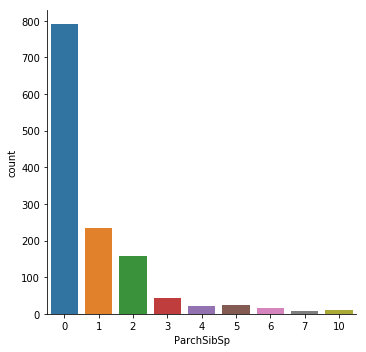

In [12]:
#g = sns.factorplot(x="Prefix", data=all_X_imputed, kind="count", size = 12)
#g = sns.factorplot(x="ParchSibSp", data=all_X_imputed, kind="count", size = 5)
#g = sns.factorplot(x="TicketCode", data=all_X_imputed, kind="count", size = 15)
#g = sns.factorplot(x="CabinCount", data=all_X_imputed, kind="count", size = 6)
#g = sns.factorplot(x="CabinCode", data=all_X_imputed, kind="count", size = 6)
#g = sns.factorplot(x="Embarked", data=all_X_imputed, kind="count", size = 6)

### Categoricals distrib by label, shows percentage with label = 1

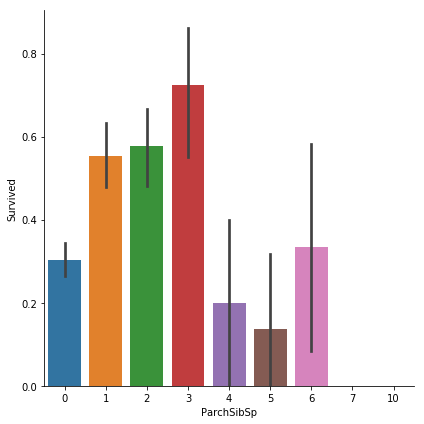

In [15]:
train_with_label = pd.concat([train_and_test_X[0:train_df.shape[0]], train_df[LABEL_COL]], axis=1)

#g = sns.factorplot(x="Embarked", y="Survived", data=train_with_label, kind="bar", size = 6)
#g = sns.factorplot(x="CabinCode", y="Survived", data=train_with_label, kind="bar", size = 12)
#g = sns.factorplot(x="TicketCode", y="Survived", data=train_with_label, kind="bar", size = 16)
#g = sns.factorplot(x="Prefix", y="Survived", data=train_with_label, kind="bar", size = 12)
#g = sns.factorplot(x="CabinCount", y="Survived", data=train_with_label, kind="bar", size = 6)
g = sns.factorplot(x="ParchSibSp", y="Survived", data=train_with_label, kind="bar", size = 6)
#g = sns.factorplot(x="SibSp", y="Survived", data=train_with_label, kind="bar", size = 6)
#g = sns.factorplot(x="Pclass", y="Survived", data=train_with_label, kind="bar", size = 6)
#g = sns.factorplot(x="ParchSibSp", y="Survived", data=train_with_label, kind="bar", size = 6)

# Not categoricals, These are messy and take a minute or so, but worth looking at
#g = sns.factorplot(x="Age", y="Survived", data=train_with_label, kind="bar", size = 30)
#g = sns.factorplot(x="Fare", y="Survived", data=train_with_label, kind="bar", size = 30)